In [94]:
%matplotlib inline
from helperFunctions import *
from constants import *
from dataAnalysisFunctions import getSEM, getCleanedSignal
import pandas as pd
from pyedflib import highlevel
from mne import io, preprocessing
from mne import channels as chans
from mne.preprocessing import ICA

In [52]:
foldername='P001'
filename='part_P001_block_S004'
filtered_data = loadData(datatype='filtered_data', foldername=foldername, filename=filename)
filtered_cleaned_data = loadData(datatype='filtered_cleaned_data', foldername=foldername, filename=filename)

In [53]:
#some_data = getTimeBoundSingleLabelData('newWord', filtered_data)
#some_cleaned_data = getTimeBoundSingleLabelData('newWord', filtered_cleaned_data)

# Get data
new_data, a, b = getMarkerBoundSingleMarkerData(blinkText, "--SpacePressed", original_data=filtered_data)
some_data=new_data[0]

In [54]:
word_num = 55
data = filtered_data

[]

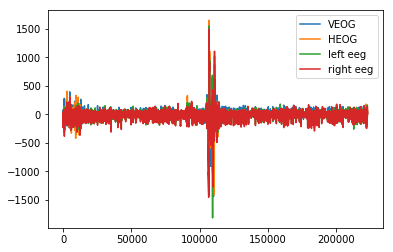

In [55]:

plt.plot(data[StreamType.EEG.value][StreamType.DATA.value][:,channels['VEOG']], label='VEOG')
plt.plot(data[StreamType.EEG.value][StreamType.DATA.value][:,channels['HEOG']], label='HEOG')
plt.plot(data[StreamType.EEG.value][StreamType.DATA.value][:,channels['left_eeg']], label='left eeg')
plt.plot(data[StreamType.EEG.value][StreamType.DATA.value][:,channels['right_eeg']], label='right eeg')

plt.legend()
plt.plot()

In [56]:
channels

{'VEOG': 0, 'HEOG': 1, 'right_eeg': 6, 'left_eeg': 7}

In [57]:
eeg_data = np.array([data[StreamType.EEG.value][StreamType.DATA.value][:,channel_index] for channel_index in channels.values()])



In [58]:
eeg_data.shape

(4, 222690)

In [59]:
eeg_fs = getEEGfs(filtered_data)

In [60]:
channel_names = ['VEOG', 'HEOG', 'Fp2', 'Fp1']#channels.keys()

In [61]:
signal_headers = highlevel.make_signal_headers(channel_names, sample_rate=eeg_fs)


In [62]:
header = highlevel.make_header(patientname=foldername)


In [63]:
highlevel.write_edf('edf_file.edf', eeg_data, signal_headers, header)


True

In [87]:
rawEDF =  io.read_raw_edf('edf_file.edf', preload=True)
ch_mapping = {'VEOG': 'eog', 'HEOG':'eog', 'Fp2':'eeg', 'Fp1':'eeg'}
rawEDF.set_channel_types(ch_mapping)
rawEDF.set_montage('standard_1020')

Extracting EDF parameters from edf_file.edf...
EDF file detected
EDF annotations detected (consider using raw.find_edf_events() to extract them)
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 222749  =      0.000 ...   890.996 secs...


<ipython-input-87-bec7f2e7c4de>:1: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  rawEDF =  io.read_raw_edf('edf_file.edf', preload=True)


<RawEDF  |  edf_file.edf, n_channels x n_times : 5 x 222750 (891.0 sec), ~8.5 MB, data loaded>

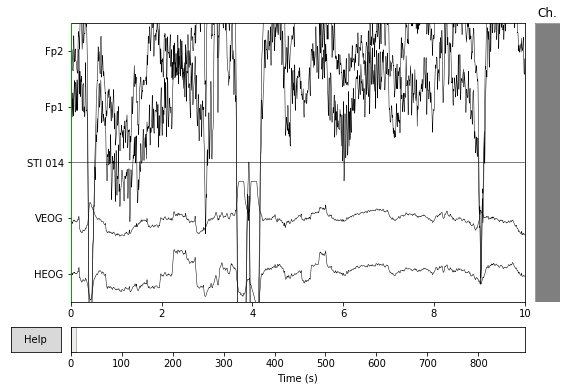

In [88]:
rawEDF.plot(n_channels=len(rawEDF.ch_names), show_options=True);

In [93]:
rawEDF.info['dig']

[{'r': array([-0.0860761, -0.0199897, -0.047986 ]),
  'ident': 1,
  'kind': 1,
  'coord_frame': 4},
 {'r': array([ 8.3000e-06,  8.6811e-02, -3.9983e-02]),
  'ident': 2,
  'kind': 1,
  'coord_frame': 4},
 {'r': array([ 0.0857939, -0.0200093, -0.048031 ]),
  'ident': 3,
  'kind': 1,
  'coord_frame': 4},
 {'r': array([-0.0294367,  0.0839171, -0.00699  ]),
  'ident': 1,
  'kind': 3,
  'coord_frame': 4},
 {'r': array([ 0.0298723,  0.0848959, -0.00708  ]),
  'ident': 2,
  'kind': 3,
  'coord_frame': 4}]

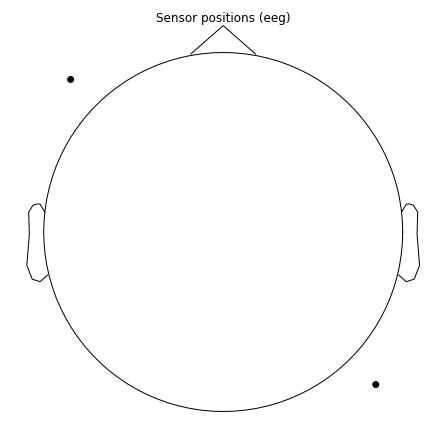

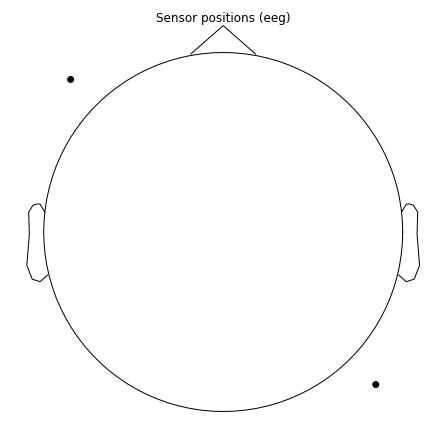

In [91]:
rawEDF.plot_sensors()

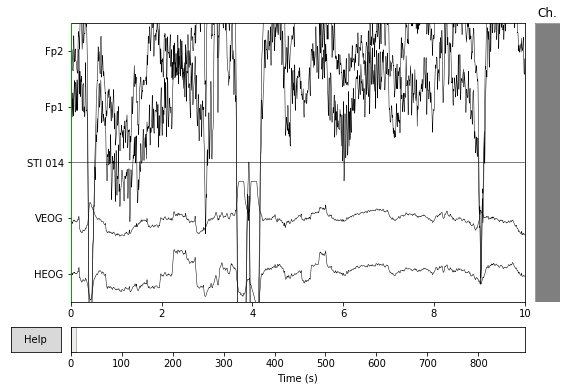

In [73]:
rawEDF.plot(n_channels=len(rawEDF.ch_names), show_options=True);


In [111]:
n_components = 5  # if float, select n_components by explained variance of PCA
method = 'fastica'  # for comparison with EEGLAB try "extended-infomax" here
decim = 3  # we need sufficient statistics, not all time points -> saves time

# we will also set state of the random number generator - ICA is a
# non-deterministic algorithm, but we want to have the same decomposition
# and the same order of components each time this tutorial is run
random_state = 3

ica = ICA(n_components=n_components, method=method, random_state=random_state)
ica.fit(rawEDF)

# reject = dict(mag=5e-12, grad=4000e-13)

eog_epochs = preprocessing.create_eog_epochs(rawEDF)
eog_average = eog_epochs.average()
print('We found %i EOG events' % average_eog.nave)
# average_eog.plot_joint()

eog_inds, scores = ica.find_bads_eog(eog_epochs)  # find via correlation

ica.plot_scores(scores, exclude=eog_inds)  # look at r scores of components
# we can see that only one component is highly correlated and that this
# component got detected by our correlation analysis (red).

ica.plot_sources(eog_average, exclude=eog_inds)  # look at source time course

Fitting ICA to data using 2 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 5 components


AssertionError: 

In [78]:
average_eog

<Evoked  |  '998' (mean, N=176), [-0.5, 0.5] sec, 2 ch, ~16 kB>

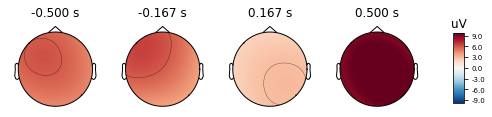

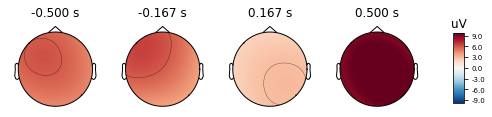

In [83]:
average_eog.plot_topomap()

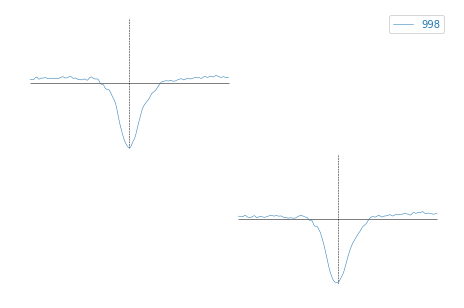

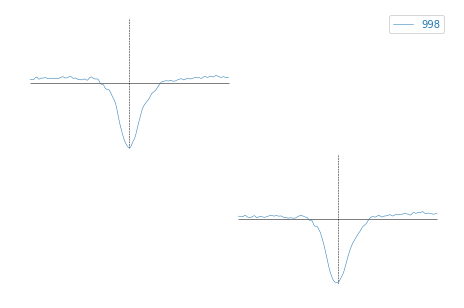

In [81]:
average_eog.plot_topo()

In [155]:
layout_from_raw = channels.make_eeg_layout(rawEDF.info)
layout_from_raw.plot()

RuntimeError: No digitization points found.

In [156]:
rawEDF.copy().set_montage('standard_1020')


ValueError: None of the sensors defined in the montage were found in the info structure. Check the channel names.

In [73]:
event_id = 998
eog_events = preprocessing.find_eog_events(rawEDF, event_id)


EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz
Filter length of 4096 samples (16.384 sec) selected
Setting up band-pass filter from 2 - 45 Hz
Filter length of 4096 samples (16.384 sec) selected
Setting up band-pass filter from 1 - 10 Hz
Filter length of 4096 samples (16.384 sec) selected
Now detecting blinks and generating corresponding events
Number of EOG events detected : 7


<ipython-input-73-3f7f82846a00>:2: RuntimeWarning: filter_length (4096) is longer than the signal (1250), distortion is likely. Reduce filter length or filter a longer signal.
  eog_events = preprocessing.find_eog_events(rawEDF, event_id)
<ipython-input-73-3f7f82846a00>:2: RuntimeWarning: filter_length (4096) is longer than the signal (1250), distortion is likely. Reduce filter length or filter a longer signal.
  eog_events = preprocessing.find_eog_events(rawEDF, event_id)
<ipython-input-73-3f7f82846a00>:2: RuntimeWarning: filter_length (4096) is longer than the signal (1250), distortion is likely. Reduce filter length or filter a longer signal.
  eog_events = preprocessing.find_eog_events(rawEDF, event_id)


In [74]:
eog_events

array([[  17,    0,  998],
       [  51,    0,  998],
       [ 337,    0,  998],
       [ 482,    0,  998],
       [ 737,    0,  998],
       [ 970,    0,  998],
       [1173,    0,  998]])